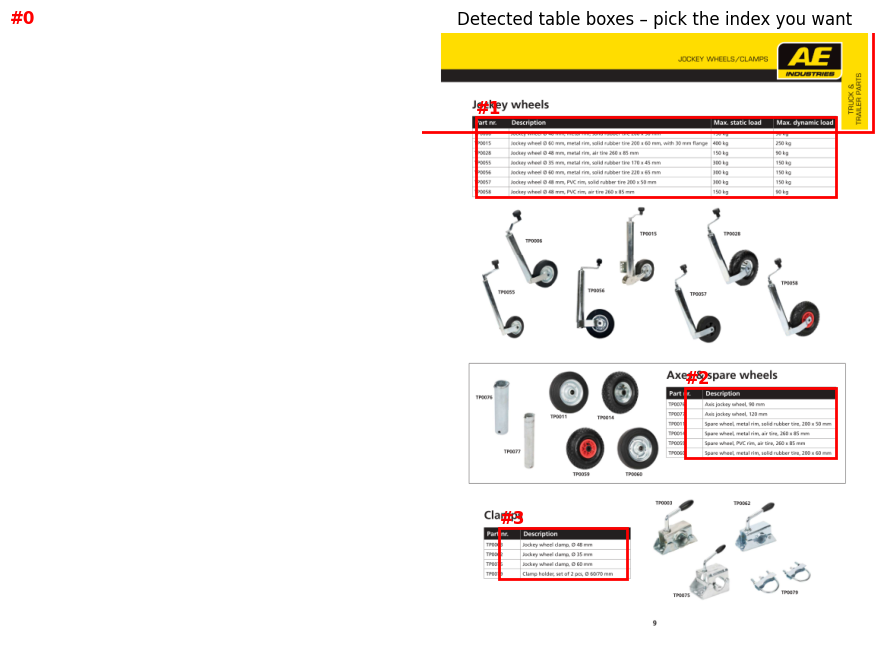

#0: bbox = (-542.400009, -8.039999999999964, 593.80000325, 129.8425013859122)
#1: bbox = (70.75448724699189, 109.77600104999999, 545.3519891000003, 215.16000375)
#2: bbox = (345.7901398878094, 465.96002175, 545.3519891000003, 558.72000825)
#3: bbox = (101.69942193054382, 650.6400150000001, 269.9131733729905, 717.839993625)


In [52]:
# --- show_tables_helper.py ------------------------------------------
# 1. Install deps if not present
!pip -q install pdfplumber pymupdf pillow matplotlib

import pdfplumber, fitz, io, matplotlib.pyplot as plt
from PIL import Image

PDF_PATH  = "/content/onepage.pdf"   #  <— change if needed
PAGE_NUM  = 1                        #  page index (1-based)

# 1️⃣  render page low-dpi for speed
page_pymupdf = fitz.open(PDF_PATH).load_page(PAGE_NUM-1)
pix = page_pymupdf.get_pixmap()      # default 72 dpi
img = Image.open(io.BytesIO(pix.tobytes()))

# 2️⃣  let pdfplumber find all tables
with pdfplumber.open(PDF_PATH) as pdf:
    plumber_page = pdf.pages[PAGE_NUM-1]
    tables = plumber_page.find_tables()

# 3️⃣  draw each bbox with an index label
fig, ax = plt.subplots(figsize=(6, 8))
ax.imshow(img); ax.axis("off")

for i, tbl in enumerate(tables):
    x0, y0, x1, y1 = tbl.bbox
    ax.add_patch(plt.Rectangle((x0, y0), x1-x0, y1-y0,
                               fill=False, edgecolor="red", lw=2))
    ax.text(x0, y0-5, f"#{i}", color="red", fontsize=12, weight="bold")

plt.title("Detected table boxes – pick the index you want")
plt.show()

for i, tbl in enumerate(tables):
    print(f"#{i}: bbox = {tbl.bbox}")


In [51]:
!pip -q install pymupdf pytesseract pillow pandas openpyxl
!apt-get -qq install -y tesseract-ocr

PDF_PATH  = "/content/onepage.pdf"
PAGE_NUM  = 1
DPI       = 300
OCR_LANG  = "eng"
CROP_BOX  = (70.75448724699189, 109.77600105, 545.3519891000003, 215.16000375)
OUT_XLSX  = "/content/output.xlsx"

import fitz, pytesseract, pandas as pd, re, io
from PIL import Image
from IPython.display import display, Markdown

# 1. raster + OCR
page = fitz.open(PDF_PATH).load_page(PAGE_NUM-1)
pix  = page.get_pixmap(matrix=fitz.Matrix(DPI/72, DPI/72),
                       clip=fitz.Rect(*CROP_BOX))
img  = Image.open(io.BytesIO(pix.tobytes()))
ocr  = pytesseract.image_to_string(img, lang=OCR_LANG)

print("------- OCR preview -------\n", ocr, "\n----------------------------")

# 2. parse rows (patch)
ocr_lines = [ln for ln in ocr.splitlines() if ln.strip()]
ocr_lines = [ln for ln in ocr_lines if not re.search(r"\bPart\s+nr", ln, re.I)]
clean_ocr = "\n".join(ocr_lines)

ROW_RE = re.compile(
    r"""^(?P<raw>[-FT]?P[A-Z0-9]{3,})\s+
        (?P<desc>.*?)\s+
        \|?\s*(?P<stat>\d+\s*kg)\s+
        (?P<dyn>\d+\s*kg)\s*$""",
    re.I | re.X | re.M,
)

OCR_MAP = str.maketrans({"O":"0","o":"0","S":"5","s":"5",
                         "I":"1","l":"1","B":"8","-":"T","F":"T","f":"T"})

rows = []
for m in ROW_RE.finditer(clean_ocr):
    part_norm = m.group("raw").translate(OCR_MAP)
    if re.fullmatch(r"TP\d{3,}", part_norm):
        rows.append({
            "Part nr.":          part_norm,
            "Description":       m.group("desc").strip(),
            "Max static load":   m.group("stat"),
            "Max dynamic load":  m.group("dyn"),
        })

df = pd.DataFrame(rows)

# 3. save + preview
with pd.ExcelWriter(OUT_XLSX, engine="openpyxl") as xl:
    df.to_excel(xl, sheet_name="Jockey Wheels", index=False)

display(Markdown(f"### ✓ Extracted **{len(df)} rows**"))
display(df)
display(Markdown(f"[**Download output.xlsx**]({OUT_XLSX})"))


------- OCR preview -------
 Part nr. Description Max. static load Max. dynamic load

 

 

 

 

 

 

 

-POO06 Jockey wheel @ 48 mm, metal rim, solid rubber tire 200 x 50 mm 150 kg 90 kg
FPO015 Jockey wheel @ 60 mm, metal rim, solid rubber tire 200 x 60 mm, with 30 mm flange | 400 kg 250 kg
P0028 Jockey wheel @ 48 mm, metal rim, air tire 260 x 85 mm 150 kg 90 kg
FPOO55 Jockey wheel @ 35 mm, metal rim, solid rubber tire 170 x 45 mm 300 kg 150 kg
P0056 Jockey wheel @ 60 mm, metal rim, solid rubber tire 220 x 65 mm 300 kg 150 kg
P0057 Jockey wheel @ 48 mm, PVC rim, solid rubber tire 200 x 50 mm 300 kg 150 kg
P0058 Jockey wheel @ 48 mm, PVC rim, air tire 260 x 85 mm 150 kg 90 kg

 

 

 
 
----------------------------


### ✓ Extracted **3 rows**

,Part nr.,Description,Max static load,Max dynamic load
0,TP0006,"Jockey wheel @ 48 mm, metal rim, solid rubber ...",150 kg,90 kg
1,TP0015,"Jockey wheel @ 60 mm, metal rim, solid rubber ...",400 kg,250 kg
2,TP0055,"Jockey wheel @ 35 mm, metal rim, solid rubber ...",300 kg,150 kg


[**Download output.xlsx**](/content/output.xlsx)